## Using Single Layer Perceptron to learn Bigrams Matrix
- Same as bigram language model, but rather than counting, use neural network
- Given a single char as input with certain model parameters to predict or guess what's the next char is 
- Then evaluate the mdoel parameters using loss function
- Gradient-based to tune the parameters to maximize the probability of next char predict

In [140]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

%config InlineBackend.figure_format = 'retina'

### Load and summarize the data

In [ ]:
seqs = pd.read_csv("oas_pair_heavy.csv", usecols=["cdr3_aa_heavy"])[
    "cdr3_aa_heavy"
].tolist()
seqs = list(set(seqs))
seqs[:10]

['ARDGDEAGVDYDFWSGYEEGSYYMDV',
 'TRGDFFMYTTELFAY',
 'ARVGGMTGTRGGN',
 'AHRRSSPSLGWFDP',
 'ARPAYRDSYAPFDY',
 'ARSRSDNRNGYNPDYFDY',
 'ARHGVPHYFDY',
 'ARPGSSFDY',
 'ARVIRDSYAHDYFDY',
 'ARERSFDY']

95% CI: [6.000, 22.000]
101344 sequences, min length 2, max length 44


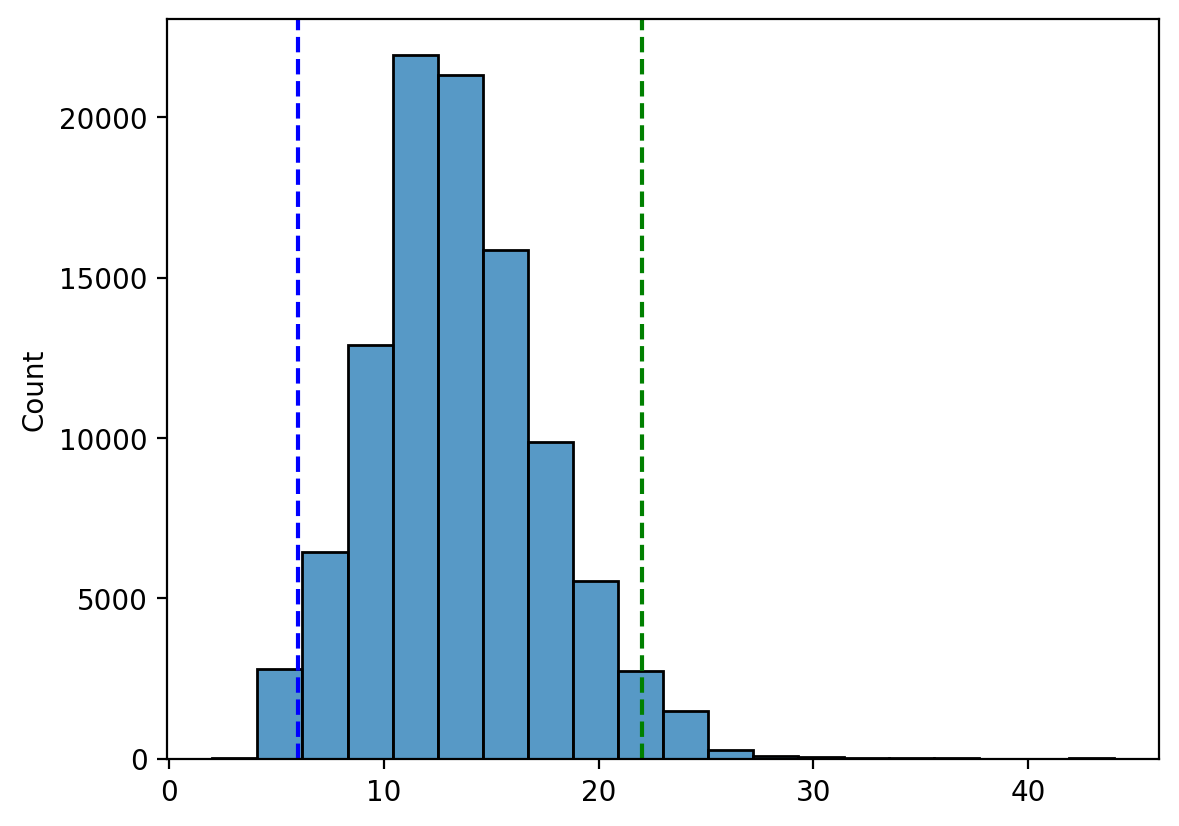

In [8]:
lengths = [len(seq) for seq in seqs]
total = len(seqs)
min_len = min(lengths)
max_len = max(lengths)
lower = np.percentile(lengths, 2.5)
upper = np.percentile(lengths, 97.5)
print(f"95% CI: [{lower:.3f}, {upper:.3f}]")
print(f"{total} sequences, min length {min_len}, max length {max_len}")
sns.histplot(lengths, bins=20, kde=False, stat="count")
plt.axvline(lower, color="blue", linestyle="--", label="2.5% (Lower)")
plt.axvline(upper, color="green", linestyle="--", label="97.5% (Upper)")
plt.show()

In [9]:
tokens = ["<S>"] + sorted(list(set("".join(seqs)))) + ["<E>"]
stoi = {t: i for i, t in enumerate(tokens)}
itos = {i: t for t, i in stoi.items()}

### Dataset

In [141]:
def bigrams_dataset(seqs: List[str]) -> torch.tensor:
    X, Y = [], []
    n = 2 # bigrams
    for seq in seqs:
        token_list = ['<S>'] + list(seq) + ['<E>']
        for i in range(len(token_list)-n+1):
            ch1, ch2 = token_list[i: i+n]
            id1, id2 = stoi[ch1], stoi[ch2]
            X.append(id1)
            Y.append(id2)
    return X, Y

In [142]:
X, Y = bigrams_dataset(seqs)

X = torch.tensor(X)
Y = torch.tensor(Y)

# index doesn't support for neural net as a input, normally convert to a one-hot vector
X_enc = F.one_hot(X, num_classes=len(stoi)).float()

### Training

In [193]:
# Initial parameters
generator = torch.Generator().manual_seed(2147483647)
W = torch.randn(22, 22, generator=generator, requires_grad=True)

num = X.nelement()
for i in range(1000):
    # Forward
    logits = torch.matmul(X_enc, W) # treat as log value
    logits = logits.exp() # fake counts
    probs = logits / logits.sum(1, keepdim=True)

    # Loss => negtive log likelihood 
    loss = -probs[torch.arange(num), Y].log().mean() + 0.1*(W**2).mean()

    # Backward
    W.grad = None
    loss.backward()

    # Update parameters
    W.data += -1 * W.grad

    if i % 10 == 0:
        print(loss.item())

    # early stop after it reach the performance of bigrams
    if loss.item() <= 2.2786:
        break

3.610347032546997
3.4668495655059814
3.3436079025268555
3.238152027130127
3.148331642150879
3.0722343921661377
3.00795316696167
2.9534716606140137
2.9068124294281006
2.866291046142578
2.8306334018707275
2.7989418506622314
2.770592451095581
2.745135545730591
2.7222187519073486
2.7015438079833984
2.6828453540802
2.6658825874328613
2.6504404544830322
2.636331081390381
2.6233887672424316
2.61147403717041
2.6004679203033447
2.590269088745117
2.5807926654815674
2.571965217590332
2.5637245178222656
2.5560169219970703
2.548795461654663
2.5420193672180176
2.5356523990631104
2.529662847518921
2.5240213871002197
2.5187032222747803
2.513683795928955
2.5089428424835205
2.5044608116149902
2.5002198219299316
2.4962029457092285
2.4923958778381348
2.4887845516204834
2.4853553771972656
2.4820971488952637
2.4789986610412598
2.4760494232177734
2.4732401371002197
2.4705617427825928
2.468006134033203
2.4655659198760986
2.463233709335327
2.461002826690674
2.4588682651519775
2.4568235874176025
2.4548633098602

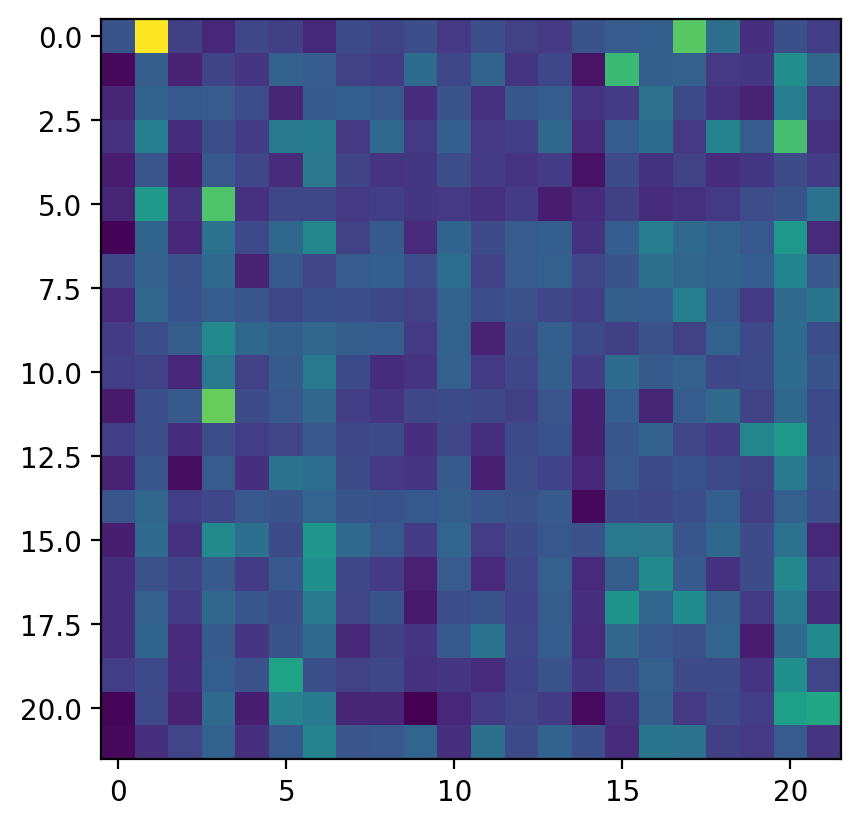

In [194]:
plt.imshow(W.data)

In [195]:
def sampling_batch_seqs(
    sample_size=10, stoi={}, itos={}, seed=2147483647
):
    generator = torch.Generator().manual_seed(seed)
    sampled_seqs = []

    start_aa = "<S>"
    end_aa = "<E>"

    start_id = stoi[start_aa]
    end_id = stoi[end_aa]
    for i in range(sample_size):
        sampled_ids = [start_id]
        while True:
            x_enc = F.one_hot(torch.tensor([start_id]), num_classes=len(stoi)).float()
            logits = torch.matmul(x_enc, W) # treat as log value
            logits = logits.exp() # fake counts
            probs = logits / logits.sum(1, keepdim=True)
            next_id = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
            sampled_ids.append(next_id)
            if next_id == end_id:
                break
        sampled_seqs.append("".join([itos[ix] for ix in sampled_ids]))
    return sampled_seqs

In [196]:
sampling_batch_seqs(
    sample_size=10, stoi=stoi, itos=itos, seed=2147483647
)

['<S>AAATAAATTATTTAAAAAATAAAAAAAAAAAAAAAAAAAATAATAAAAAAAAAAAATRATTAATATIAAAAATAAAAAAAAAAAAARAAAAAAAAAAAAAAAAGTTATAAAAAAAAALAAAAATARAAQAT<E>',
 '<S>AAATAN<S>NQAAAAAAAVAAAACAAAAAATAAAAATA<S>AAAAAVAAAAAAATTATAAAAAAAAAATAAAATAAAAAAAAAAAAATAAAAAANAAAAAAATAAAAAATAAAAAAAAAAAAAAAATAAAAATTA<S>AATTAAAAHAAAAAAAAAAATAAAATAAAAAAAAYAAAAATCAAAAAATAASTIATRTAATAAQAAAATTAAATATANATAAAAAAAAAAAAMAAAAAAAAATNTTAAT<E>',
 '<S>ARTWGAASALGAAAEAATAAAAAAAAATATATTAAAAAAATAAAAAAAAAATAAAAAAA<S>AAAHAAAA<S>AAATIAATAAAAAIAAAAAAAAAAAAAATAARYACAAAAAAAAATAAYAATTAATTAAAATKAAAIAA<E>',
 '<S>AAAAAAAAAAAHAAMAAAATAAAAAATAATA<S>MAA<E>',
 '<S>AAA<S>AAHTAYAATTAALTVTWAAAAAATGRAAAAANKAAAAAAAAAAVDATTATAATALTAAADAA<S>AAAAAATAATAAAACAAAAAAAAAAAAAATAATAVAAAAATAAAAAATATTAAAAAAAAATTMATATQAAAAASAAAAAATTAIAATAAAATAAATAAAAAAVAAAAATATATAAVAAAVAATTAACAAATATAAAATSTAAAAAATAAAAATAAAAATAA<S>AAAAAAAATAAVAAKAAAAAAAAAAAATAAAATTAAAAAAAAAAATAAAAAAATAATAAAATASTFTATATAAAAAAAAAAAAAHATAITAATAAAAAAAAAATAAAATTASAAAGAAAATEAAAAAAAAATTAANATAAAATAAVTAAAAAAAAAAATA